In [1]:
# AIM OF THIS NOTE BOOK

## optional - download dataset
# https://cs.stanford.edu/~acoates/stl10/
# wget https://raw.githubusercontent.com/mttk/STL10/master/stl10_input.py
# python stl10_input.py

## generate random lines

## overlay lines to images

## train yolo with images with line

In [2]:
SEED = 0
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

In [3]:
%load_ext autoreload
%autoreload 2

import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from make_line import make_data, get_grid

In [5]:
# x  (None,64,64)
# y0 (None,64,5)     - object,relstartx,relstarty,shapex,shapey
# y1 (None,64,64,64) - 64x(64,64) mask

szx,szy,szz=64,64,64
smx,smy=8,8
x_train, y_train0, y_train1 = make_data(N=1024)
x_val, y_val0, y_val1 = make_data(N=100)
x_test, y_test0, y_test1 = make_data(N=5)
grid, grid_anchor = get_grid()

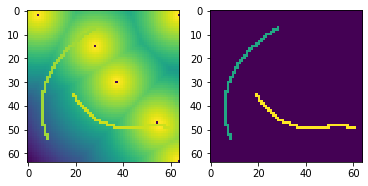

In [6]:
ind = -2
plt.subplot(121)
plt.imshow(x_train[ind,:].squeeze())
region = np.argwhere(y_train0[ind,:,-1]==1)
tmp = np.zeros((szx,szy))
for r in region.squeeze():
    tmp[y_train1[ind,r,:,:].squeeze()==1]=r+1
plt.subplot(122)
plt.imshow(tmp)

In [7]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

from keras.models import Sequential, load_model
from keras import optimizers as opt
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Reshape, Conv2DTranspose
from keras.callbacks import LearningRateScheduler,EarlyStopping

from keras.models import Model
from keras.layers import Permute, Reshape, Lambda, add, Input, Concatenate
from keras.layers import Conv2D, BatchNormalization, LeakyReLU
from keras import regularizers, initializers
import tensorflow as tf
from keras import backend as K


Using TensorFlow backend.


In [24]:
def viz_results(x_test,y_test0,ytest1,pred):
    obj_ind = -1
    #for ind in range(pred.shape[0]):
    for ind in range(5):

        plt.figure(ind,figsize=(20,10))

        # GROUND TRUTH
        plt.subplot(331)
        plt.title('sample index: {}'.format(ind))
        plt.imshow(x_test[ind,:].squeeze())

        region = np.argwhere(y_test0[ind,:,obj_ind]==1).ravel()
        obj_real = np.zeros((szx,szy))
        for r in region:
            obj_real[grid==r]=1
        obj_real = np.reshape(y_test0[ind,:,obj_ind],(smx,smy))

        plt.subplot(332)
        plt.title('obj or not - truth'.format())
        plt.imshow(obj_real,cmap='gray')
        obj = np.reshape(pred[0][ind,:,obj_ind],(smx,smy))

        ax = plt.subplot(333)
        plt.title('obj or not - truth - actual val'.format())
        plt.plot(y_test0[ind,:,obj_ind])
        ax.set_ylim(0,1)

        # PREDICTED
        plt.subplot(334)
        plt.title('obj or not - pred'.format())
        plt.imshow(obj,cmap='gray')
        plt.subplot(335)
        plt.title('obj or not - pred - actual val'.format())
        plt.imshow(obj,vmin=0,vmax=1,cmap='gray')

        ax = plt.subplot(336)
        plt.title('obj or not - pred - actual val'.format())
        plt.plot(pred[0][ind,:,obj_ind])
        ax.set_ylim(0,1)

        if len(pred)>1:
            plt.subplot(337)
            plt.title('mask - pred'.format())
            argmax = np.argmax(pred[0][ind,:,obj_ind])
            plt.title('argmax {}'.format(argmax))
            plt.imshow(pred[1][ind,argmax,:,:].squeeze(),cmap='gray')

In [48]:
SEED = 0
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)


# simple yolo
#   https://gist.github.com/msrks/ce613e91a98868d4a059c6c5c5e30ba3
# vanillay conv cannot prediction coord
#   https://eng.uber.com/coordconv/
# alternative archetectures.
#   https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e
#   https://github.com/jianing-sun/Mask-YOLO
# actual yolos
#   https://github.com/ksanjeevan/dourflow/blob/master/net/netarch.py
#   https://github.com/guigzzz/Keras-Yolo-v2


epsilon = 1E-8
def compute_obj_loss(y_true,y_pred):
    return tf.keras.backend.binary_crossentropy(y_true[...,-1], y_pred[...,-1])

def compute_coord_loss(y_true,y_pred):
    loss_px = tf.squared_difference(y_true[...,0], y_pred[...,0])
    loss_py = tf.squared_difference(y_true[...,1], y_pred[...,1])
    loss_wx = tf.squared_difference(y_true[...,2], y_pred[...,2])
    loss_wy = tf.squared_difference(y_true[...,3], y_pred[...,3])
    loss_pos = tf.multiply(y_true[...,-1],tf.add(loss_px,loss_py))
    loss_width = tf.multiply(y_true[...,-1],tf.add(loss_wx,loss_wy))
    return loss_pos+loss_width

def compute_iou_loss(y_true,y_pred):
    # ref. https://github.com/ksanjeevan/dourflow/blob/master/net/netloss.py
    def process_boxes(A):
        # ALign x-w, y-h
        A_xy = A[..., 0:2]
        A_wh = A[..., 2:4]
        
        A_wh_half = A_wh / 2.
        # Get x_min, y_min
        A_mins = A_xy - A_wh_half
        # Get x_max, y_max
        A_maxes = A_xy + A_wh_half
        
        return A_mins, A_maxes, A_wh
    
    # Process two sets
    A2_mins, A2_maxes, A2_wh = process_boxes(y_pred)
    A1_mins, A1_maxes, A1_wh = process_boxes(y_true)
    
    # Intersection as min(Upper1, Upper2) - max(Lower1, Lower2)
    intersect_mins  = K.maximum(A2_mins,  A1_mins)
    intersect_maxes = K.minimum(A2_maxes, A1_maxes)
    
    # Getting the intersections in the xy (aka the width, height intersection)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)

    # Multiply to get intersecting area
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # Values for the single sets
    true_areas = A1_wh[..., 0] * A1_wh[..., 1]
    pred_areas = A2_wh[..., 0] * A2_wh[..., 1]
    
    # Compute union for the IoU
    union_areas = pred_areas + true_areas - intersect_areas
    
    # probably not necssary...
    iou_loss = tf.multiply(y_true[...,-1], intersect_areas / (union_areas+epsilon) )
    
    return iou_loss


def vec_loss(y_true, y_pred):
    
    lambda_obj = 5.0
    lambda_coord = 1.0
    lambda_iou = 1.0
    
    obj_loss = compute_obj_loss(y_true, y_pred)
    obj_loss = tf.multiply(lambda_obj,obj_loss)
    
    coord_loss = compute_coord_loss(y_true, y_pred)
    coord_loss = tf.multiply(lambda_coord,coord_loss)
    
    iou_loss = compute_iou_loss(y_true, y_pred)
    iou_loss = tf.multiply(lambda_iou,iou_loss)
    
    total_loss = tf.add(tf.add(obj_loss,coord_loss),iou_loss)
    
    return tf.reduce_mean(total_loss)


def conv_batch_lrelu(input_tensor, numfilter, dim, strides=2):
    # https://github.com/guigzzz/Keras-Yolo-v2/blob/f61286371cdc2d470e0811234f552c70bbd5caba/yolo_layer_utils.py#L18
    input_tensor = Conv2D(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

def convt_batch_lrelu(input_tensor, numfilter, dim, strides=2):
    input_tensor = Conv2DTranspose(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

MASK = 'MASK'
VECTOR = 'VECTOR'

inputs = Input(shape=(szx,szy,1))

# down sample
xd = conv_batch_lrelu(inputs, 64, 3)
xd = conv_batch_lrelu(xd, 64, 3)
xd = conv_batch_lrelu(xd, 128, 3)
xd = conv_batch_lrelu(xd, 256, 3)

# bottle neck
x=Flatten()(xd)
x=Dense(256)(x) # # filter size ratio between conv and dense needs to be tuned!
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(0.5)(x)
x=Dense(256)(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(0.5)(x)
x=Dense(smx*smy*5)(x)
x=Reshape((smx*smy,5))(x)

# output split - split output to have varying activations for pos,width, and obj
# output: pos and width
x_pos_width = Lambda(lambda x: x[..., 0:4])(x)
x_pos_width=Activation('linear')(x_pos_width)
x_pos_width=Lambda(lambda x: K.clip(x,0.,1.))(x_pos_width)

# output: sigmoid
x_obj = Lambda(lambda x: K.expand_dims(x[..., -1],axis=-1))(x)
x_obj=Activation('sigmoid')(x_obj)

# merge outputs
vecs = Concatenate(axis=-1,name=VECTOR)([x_pos_width,x_obj])
model = Model(inputs=inputs, outputs=vecs)
model.summary()
print(x_train.shape,y_train0.shape,y_train1.shape)


# very nice ref. https://github.com/ksanjeevan/dourflow/blob/master/yolov2.py
# opt.Adam, opt.RMSprop

batch_size = 8
epochs=100
lr=1E-3
decay=1E-4
patience=10
beta_1=0.9
beta_2=0.999


early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=patience,
                              verbose=0,
                              mode='min')
callbacks = [early_stopping]

optimizer = opt.Adam(lr=lr,beta_1=beta_1, beta_2=beta_2, decay=decay)
model.compile(loss=vec_loss, optimizer=optimizer)
history = model.fit(x_train, y_train0,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1, 
                    validation_data=(x_val, y_val0),
                    callbacks=callbacks)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 32, 32, 64)   576         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 32, 32, 64)   256         conv2d_33[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_33 (LeakyReLU)      (None, 32, 32, 64)   0           batch_normalization_45[0][0]     
__________________________________________________________________________________________________
conv2d_34 

1024/1024 [==============================] - 1s 1ms/step - loss: 0.6905 - val_loss: 0.8422
Epoch 17/100
1024/1024 [==============================] - 1s 1ms/step - loss: 0.6671 - val_loss: 0.8362
Epoch 18/100
1024/1024 [==============================] - 1s 1ms/step - loss: 0.6495 - val_loss: 0.9294
Epoch 19/100
1024/1024 [==============================] - 1s 1ms/step - loss: 0.6330 - val_loss: 0.8449
Epoch 20/100
1024/1024 [==============================] - 1s 1ms/step - loss: 0.6110 - val_loss: 0.8345
Epoch 21/100
1024/1024 [==============================] - 1s 1ms/step - loss: 0.5821 - val_loss: 0.8506
Epoch 22/100
1024/1024 [==============================] - 1s 1ms/step - loss: 0.5770 - val_loss: 0.8872
Epoch 23/100
1024/1024 [==============================] - 1s 1ms/step - loss: 0.5665 - val_loss: 0.9210
Epoch 24/100
1024/1024 [==============================] - 1s 1ms/step - loss: 0.5539 - val_loss: 0.9673
Epoch 25/100
1024/1024 [==============================] - 1s 1ms/step - loss:

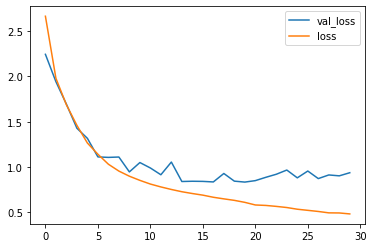

In [49]:
#for k,v in history.history.items():
#    history.history[k]=v/v[0]   
df = pd.DataFrame(history.history)
df.plot()

In [47]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

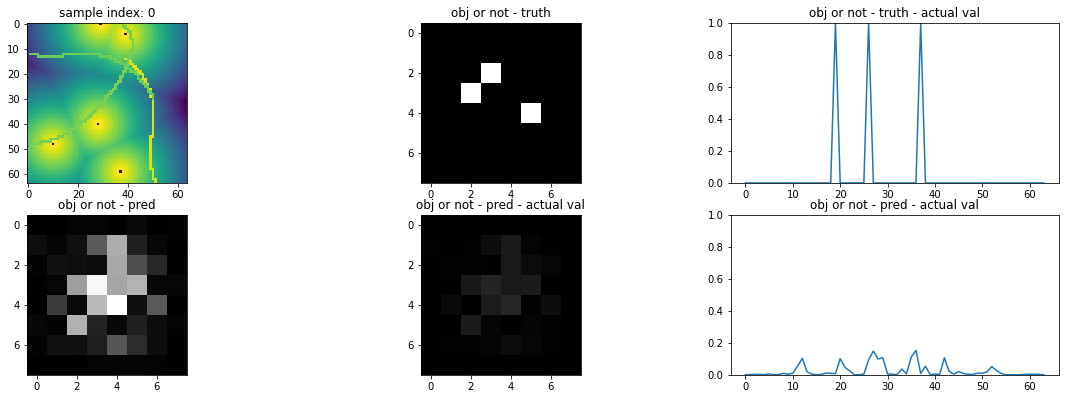

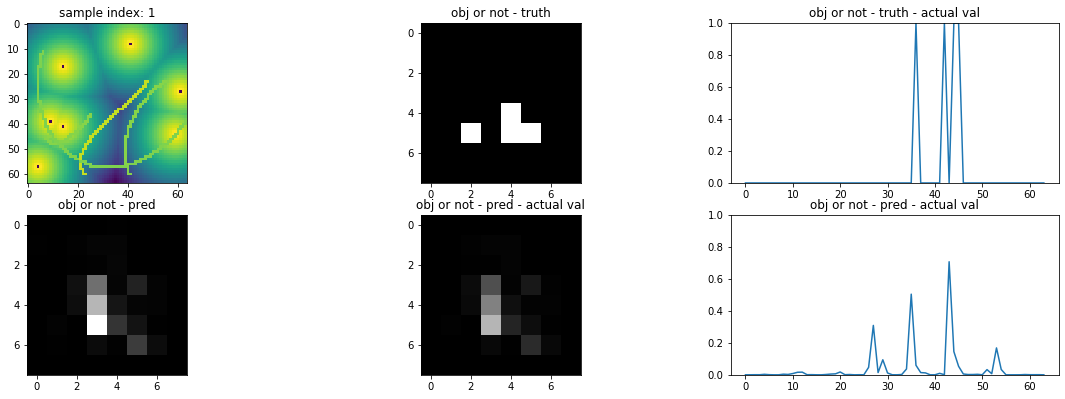

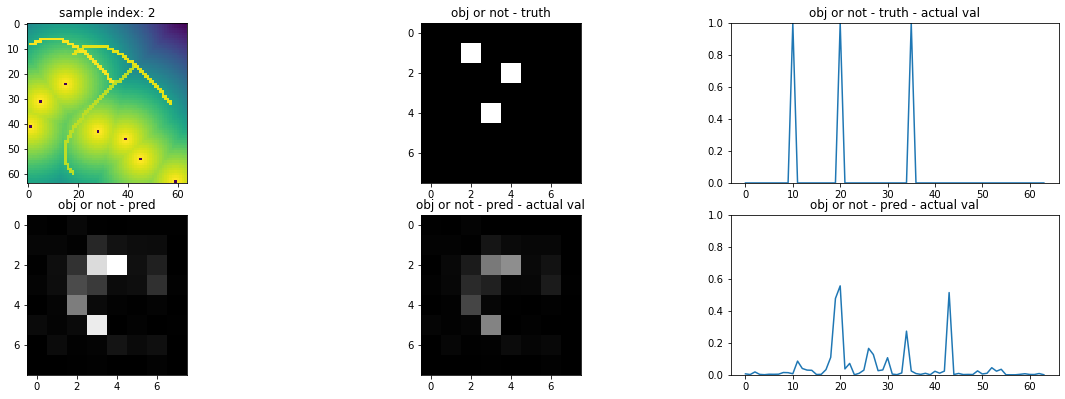

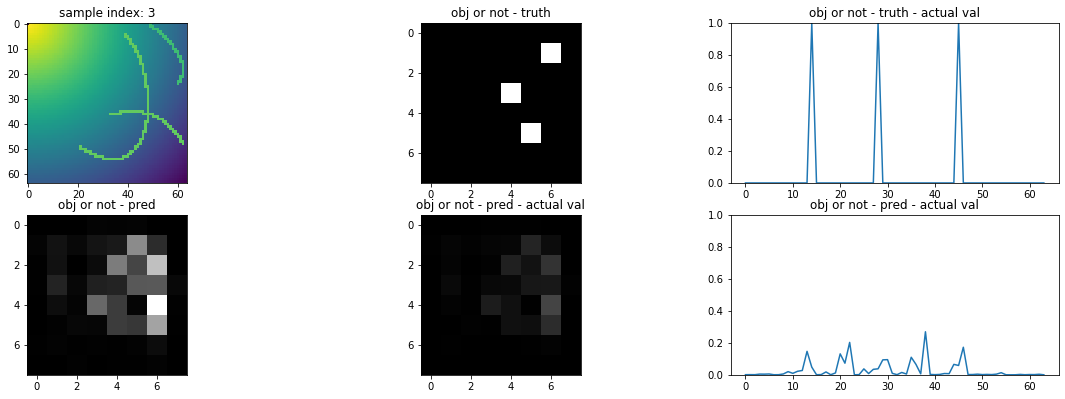

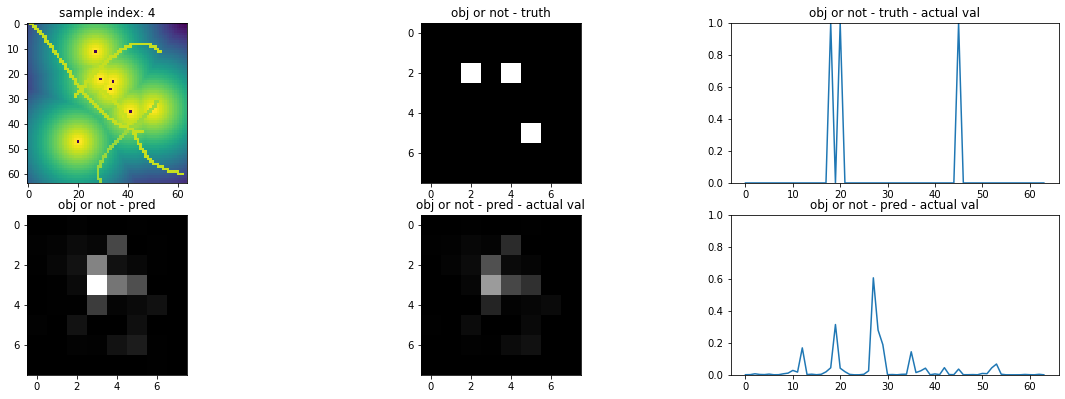

In [44]:
#x_test, y_test0, y_test1 = x_testA, y_test0A, y_test1A
#x_test, y_test0, y_test1 = x_train, y_train0, y_train1
#x_test, y_test0, y_test1 = x_val, y_val0, y_val1
pred = model.predict(x_test)
pred = [pred]
viz_results(x_test,y_test0,y_test1,pred)